In [1]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd 
from pandas import concat
import numpy as np
from numpy import cov
from datetime import datetime
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Model, Sequential, save_model
from keras.layers import LSTM, Dense, Dropout, Activation, Input, RepeatVector, TimeDistributed
from keras.regularizers import l1
from keras.callbacks import TensorBoard
from keras.optimizers import Adam, Adadelta
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler 
from sklearn.pipeline import Pipeline

seed = 7
np.random.seed(seed)


Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('D:/data/Mendeley Data/raw.csv')
#rename ground truth
del dataset['AccZ']
del dataset['GyroX']
del dataset['GyroY']
dataset.columns = ['AccX', ' AccY', ' GyroZ', 'Target']
dataset = dataset.rename(columns = \
                                    {'AccX':'acc_x',' AccY':'acc_y',' GyroZ':'gyro_z'})

In [3]:
dataset['category'] = dataset['Target'].map({ 1: 'aggressive_acceleration', 2:'aggressive_right_turn', 3:'aggressive_left_turn',\
                                            4: 'aggressive_braking', })
del dataset['Target']


In [4]:
dataset['second'] = (dataset.index)*0.5
dataset.iloc[:]

,acc_x,acc_y,gyro_z,category,second
0,0.162598,-0.086670,0.824427,aggressive_acceleration,0.0
1,0.175781,-0.100586,0.832061,aggressive_acceleration,0.5
2,0.322754,-0.140381,0.587786,aggressive_acceleration,1.0
3,0.480225,-0.226807,-0.251908,aggressive_acceleration,1.5
4,0.426025,-0.253906,-0.106870,aggressive_acceleration,2.0
...,...,...,...,...,...
1109,0.472900,-0.431152,8.893130,aggressive_braking,554.5
1110,0.459961,-0.227051,1.282443,aggressive_braking,555.0
1111,0.419189,-0.192871,1.183206,aggressive_braking,555.5
1112,0.308838,-0.090088,0.656489,aggressive_braking,556.0


In [5]:
dataset['eng_acc_x'] = (dataset['acc_x'].pow(2))
dataset['eng_acc_y'] = (dataset['acc_y'].pow(2))
dataset['eng_gyro_z'] = (dataset['gyro_z'].pow(2))

dataset['slope_acc_x'] = dataset.iloc[:, 0].diff().div(dataset.second.diff(), axis=0)
dataset['slope_acc_y'] = dataset.iloc[:, 1].diff().div(dataset.second.diff(), axis=0)
dataset['slope_gyro_z'] = dataset.iloc[:, 5].diff().div(dataset.second.diff(), axis=0)

dataset['time'] = dataset['second']
dataset.set_index('second', inplace=True)

dataset


,acc_x,acc_y,gyro_z,category,eng_acc_x,eng_acc_y,eng_gyro_z,slope_acc_x,slope_acc_y,slope_gyro_z,time
second,,,,,,,,,,,
0.0,0.162598,-0.086670,0.824427,aggressive_acceleration,0.026438,0.007512,0.679681,NaN,NaN,NaN,0.0
0.5,0.175781,-0.100586,0.832061,aggressive_acceleration,0.030899,0.010118,0.692326,0.026367,-0.027832,0.008922,0.5
1.0,0.322754,-0.140381,0.587786,aggressive_acceleration,0.104170,0.019707,0.345493,0.293945,-0.079590,0.146542,1.0
1.5,0.480225,-0.226807,-0.251908,aggressive_acceleration,0.230616,0.051441,0.063458,0.314941,-0.172852,0.252891,1.5
2.0,0.426025,-0.253906,-0.106870,aggressive_acceleration,0.181498,0.064468,0.011421,-0.108398,-0.054199,-0.098236,2.0
...,...,...,...,...,...,...,...,...,...,...,...
554.5,0.472900,-0.431152,8.893130,aggressive_braking,0.223635,0.185892,79.087757,0.578613,-0.781250,0.379856,554.5
555.0,0.459961,-0.227051,1.282443,aggressive_braking,0.211564,0.051552,1.644659,-0.025879,0.408203,-0.024141,555.0
555.5,0.419189,-0.192871,1.183206,aggressive_braking,0.175720,0.037199,1.399977,-0.081543,0.068359,-0.071689,555.5


In [6]:
#window feature seclection for acc_x
acc_x = dataset['acc_x']
shifted_acc_x = acc_x.shift(1)
window_shifted_acc_x = shifted_acc_x.rolling(window=20)
mean_window_acc_x = window_shifted_acc_x.mean().fillna(value =0, inplace=False)
#mean_window_acc_x = window_shifted_acc_x.mad()
min_window_acc_x = window_shifted_acc_x.min().fillna(value =0, inplace=False)
max_window_acc_x = window_shifted_acc_x.max().fillna(value =0, inplace=False)
var_window_acc_x = window_shifted_acc_x.var().fillna(value =0, inplace=False)
std_window_acc_x = window_shifted_acc_x.std().fillna(value =0, inplace=False)

In [7]:
eng_acc_x = dataset['eng_acc_x']
shifted_eng_acc_x = eng_acc_x.shift(1)
window_shifted_eng_acc_x = shifted_eng_acc_x.rolling(window=20)
engy_window_acc_x = window_shifted_eng_acc_x.mean().fillna(value =0, inplace=False)

slope_acc_x = dataset['slope_acc_x']
shifted_slope_acc_x = slope_acc_x.shift(1)
window_shifted_slope_acc_x = shifted_slope_acc_x.rolling(window=20)
slope_window_acc_x = window_shifted_slope_acc_x.mean().fillna(value =0, inplace=False)

In [8]:
#window feature seclection for acc_y
acc_y = dataset['acc_y']
shifted_acc_y = acc_y.shift(1)
window_shifted_acc_y = shifted_acc_y.rolling(window=20)
mean_window_acc_y = window_shifted_acc_y.mean().fillna(value =0, inplace=False)
min_window_acc_y = window_shifted_acc_y.min().fillna(value =0, inplace=False)
max_window_acc_y = window_shifted_acc_y.max().fillna(value =0, inplace=False)
var_window_acc_y = window_shifted_acc_y.var().fillna(value =0, inplace=False)
std_window_acc_y = window_shifted_acc_y.std().fillna(value =0, inplace=False)
eng_acc_y = dataset['eng_acc_y']
shifted_eng_acc_y = eng_acc_y.shift(1)
window_shifted_eng_acc_y = shifted_eng_acc_y.rolling(window=20)
engy_window_acc_y = window_shifted_eng_acc_y.mean().fillna(value =0, inplace=False)

slope_acc_y = dataset['slope_acc_y']
shifted_slope_acc_y = slope_acc_y.shift(1)
window_shifted_slope_acc_y = shifted_slope_acc_y.rolling(window=20)
slope_window_acc_y = window_shifted_slope_acc_y.mean().fillna(value =0, inplace=False)

In [9]:
#window feature seclection for gyro_z
gyro_z = dataset['gyro_z']
shifted_gyro_z = gyro_z.shift(1)
window_shifted_gyro_z = shifted_gyro_z.rolling(window=20)
mean_window_gyro_z = window_shifted_gyro_z.mean().fillna(value =0, inplace=False)
min_window_gyro_z = window_shifted_gyro_z.min().fillna(value =0, inplace=False)
max_window_gyro_z = window_shifted_gyro_z.max().fillna(value =0, inplace=False)
var_window_gyro_z = window_shifted_gyro_z.var().fillna(value =0, inplace=False)
std_window_gyro_z = window_shifted_gyro_z.std().fillna(value =0, inplace=False)
eng_gyro_z = dataset['eng_gyro_z']
shifted_eng_gyro_z = eng_gyro_z.shift(1)
window_shifted_eng_gyro_z = shifted_eng_gyro_z.rolling(window=20)
engy_window_gyro_z = window_shifted_eng_gyro_z.mean().fillna(value =0, inplace=False)

slope_gyro_z = dataset['slope_gyro_z']
shifted_slope_gyro_z = slope_gyro_z.shift(1)
window_shifted_slope_gyro_z = shifted_slope_gyro_z.rolling(window=20)
slope_window_gyro_z = window_shifted_slope_gyro_z.mean().fillna(value =0, inplace=False)

In [10]:

dataset_acc_gyro_xyz = concat([acc_x, mean_window_acc_x, min_window_acc_x, max_window_acc_x,\
                               var_window_acc_x, std_window_acc_x, engy_window_acc_x, \
                               acc_y, mean_window_acc_y, min_window_acc_y, max_window_acc_y,\
                               var_window_acc_y, std_window_acc_y, engy_window_acc_y, \
                               gyro_z, mean_window_gyro_z, min_window_gyro_z, max_window_gyro_z,\
                               var_window_gyro_z, std_window_gyro_z, engy_window_gyro_z], axis=1)
dataset_acc_gyro_xyz.columns = ['acc_x', 'mean_acc_x', 'min_acc_x', 'max_acc_x', 'var_acc_x', \
                                'std_acc_x', 'eng_acc_x', \
                                'acc_y', 'mean_acc_y', 'min_acc_y', 'max_acc_y', 'var_acc_y', \
                                'std_acc_y', 'eng_acc_y', \
                                'gyro_z', 'mean_gyro_z', 'min_gyro_z', 'max_gyro_z', 'var_gyro_z', \
                                'std_gyro_z', 'eng_gyro_z']
dataset_acc_gyro_xyz['slope_acc_x'] = slope_window_acc_x
dataset_acc_gyro_xyz['slope_acc_y'] = slope_window_acc_y
dataset_acc_gyro_xyz['slope_gyro_z'] = slope_window_gyro_z
dataset_acc_gyro_xyz['category']= dataset['category'] 
dataset_acc_gyro_xyz['time']= dataset['time'] 

dataset_acc_gyro_xyz

,acc_x,mean_acc_x,min_acc_x,max_acc_x,var_acc_x,std_acc_x,eng_acc_x,acc_y,mean_acc_y,min_acc_y,...,min_gyro_z,max_gyro_z,var_gyro_z,std_gyro_z,eng_gyro_z,slope_acc_x,slope_acc_y,slope_gyro_z,category,time
second,,,,,,,,,,,,,,,,,,,,,
0.0,0.162598,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.086670,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,aggressive_acceleration,0.0
0.5,0.175781,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.100586,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,aggressive_acceleration,0.5
1.0,0.322754,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.140381,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,aggressive_acceleration,1.0
1.5,0.480225,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.226807,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,aggressive_acceleration,1.5
2.0,0.426025,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.253906,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,aggressive_acceleration,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554.5,0.472900,0.277698,-0.04541,0.631592,0.058767,0.242419,0.132945,-0.431152,-0.076709,-0.352295,...,0.137405,3.763359,0.733041,0.856178,2.285721,-0.038208,0.032104,-0.028628,aggressive_braking,554.5
555.0,0.459961,0.272546,-0.04541,0.631592,0.056063,0.236777,0.127542,-0.227051,-0.090149,-0.431152,...,0.137405,8.893130,3.646008,1.909452,6.159822,-0.010303,-0.026880,-0.010806,aggressive_braking,555.0
555.5,0.419189,0.270386,-0.04541,0.631592,0.055108,0.234750,0.125461,-0.192871,-0.088672,-0.431152,...,0.137405,8.893130,3.552899,1.884913,6.238066,-0.004321,0.002954,-0.004162,aggressive_braking,555.5


In [11]:

dataset_acc_gyro_xyz.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1114 entries, 0.0 to 556.5
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   acc_x         1114 non-null   float64
 1   mean_acc_x    1114 non-null   float64
 2   min_acc_x     1114 non-null   float64
 3   max_acc_x     1114 non-null   float64
 4   var_acc_x     1114 non-null   float64
 5   std_acc_x     1114 non-null   float64
 6   eng_acc_x     1114 non-null   float64
 7   acc_y         1114 non-null   float64
 8   mean_acc_y    1114 non-null   float64
 9   min_acc_y     1114 non-null   float64
 10  max_acc_y     1114 non-null   float64
 11  var_acc_y     1114 non-null   float64
 12  std_acc_y     1114 non-null   float64
 13  eng_acc_y     1114 non-null   float64
 14  gyro_z        1114 non-null   float64
 15  mean_gyro_z   1114 non-null   float64
 16  min_gyro_z    1114 non-null   float64
 17  max_gyro_z    1114 non-null   float64
 18  var_gyro_z    1114 non-

In [12]:
data = dataset_acc_gyro_xyz

In [13]:
data['agg_LLC'] =  np.where(((data['acc_y']>2)|(data['slope_acc_y']>5))|\
                            ((data['gyro_z']<-0.6)|(data['slope_gyro_z']<-0.6)),1,0)

data['agg_RLC'] =  np.where(((data['acc_y']<-2)|(data['slope_acc_y']<-5))|\
                           ((data['gyro_z']>0.6)|(data['slope_gyro_z']>0.6)),1,0)
 


In [14]:
data['agg_LT'] =  np.where(((data['acc_y']>2)|(data['slope_acc_y']>5))|\
                            (data['eng_acc_y']>0.3)&((data['gyro_z']>0.6)|(data['slope_gyro_z']>0.6)),1,0)

data['agg_RT'] =  np.where(((data['acc_y']<-2)|(data['slope_acc_y']<-5))|\
                         (data['eng_acc_y']>0.3)&((data['gyro_z']<-0.6)|(data['slope_gyro_z']<-0.6)),1,0)
 

In [15]:
data['agg_ACC'] =  np.where(((data['acc_x']>2)|(data['slope_acc_x']>5)),1,0)

data['agg_Brake'] =  np.where(((data['acc_x']<-2)|(data['slope_acc_x']<-5)),1,0)
 

#agg_ACC_Brake = ['acc_x','slope_acc_x', 'agg_ACC', 'agg_Brake','category']
new_true_value = ['agg_ACC','agg_Brake', 'agg_LLC', 'agg_RLC', 'agg_LT', 'agg_RT', 'category']
features = ['acc_x', 'mean_acc_x', 'min_acc_x', 'max_acc_x', 'var_acc_x', 'std_acc_x', 'eng_acc_x',\
            'acc_y', 'mean_acc_y', 'min_acc_y', 'max_acc_y', 'var_acc_y', 'std_acc_y', 'eng_acc_y',\
            'gyro_z', 'mean_gyro_z', 'min_gyro_z', 'max_gyro_z', 'var_gyro_z', 'std_gyro_z', \
            'eng_gyro_z', 'slope_acc_x', 'slope_acc_y', 'slope_gyro_z', 'time']
data = data[features + new_true_value]
data

,acc_x,mean_acc_x,min_acc_x,max_acc_x,var_acc_x,std_acc_x,eng_acc_x,acc_y,mean_acc_y,min_acc_y,...,slope_acc_y,slope_gyro_z,time,agg_ACC,agg_Brake,agg_LLC,agg_RLC,agg_LT,agg_RT,category
second,,,,,,,,,,,,,,,,,,,,,
0.0,0.162598,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.086670,0.000000,0.000000,...,0.000000,0.000000,0.0,0,0,0,1,0,0,aggressive_acceleration
0.5,0.175781,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.100586,0.000000,0.000000,...,0.000000,0.000000,0.5,0,0,0,1,0,0,aggressive_acceleration
1.0,0.322754,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.140381,0.000000,0.000000,...,0.000000,0.000000,1.0,0,0,0,0,0,0,aggressive_acceleration
1.5,0.480225,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.226807,0.000000,0.000000,...,0.000000,0.000000,1.5,0,0,0,0,0,0,aggressive_acceleration
2.0,0.426025,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-0.253906,0.000000,0.000000,...,0.000000,0.000000,2.0,0,0,0,0,0,0,aggressive_acceleration
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554.5,0.472900,0.277698,-0.04541,0.631592,0.058767,0.242419,0.132945,-0.431152,-0.076709,-0.352295,...,0.032104,-0.028628,554.5,0,0,0,1,0,0,aggressive_braking
555.0,0.459961,0.272546,-0.04541,0.631592,0.056063,0.236777,0.127542,-0.227051,-0.090149,-0.431152,...,-0.026880,-0.010806,555.0,0,0,0,1,0,0,aggressive_braking
555.5,0.419189,0.270386,-0.04541,0.631592,0.055108,0.234750,0.125461,-0.192871,-0.088672,-0.431152,...,0.002954,-0.004162,555.5,0,0,0,1,0,0,aggressive_braking


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1114 entries, 0.0 to 556.5
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   acc_x         1114 non-null   float64
 1   mean_acc_x    1114 non-null   float64
 2   min_acc_x     1114 non-null   float64
 3   max_acc_x     1114 non-null   float64
 4   var_acc_x     1114 non-null   float64
 5   std_acc_x     1114 non-null   float64
 6   eng_acc_x     1114 non-null   float64
 7   acc_y         1114 non-null   float64
 8   mean_acc_y    1114 non-null   float64
 9   min_acc_y     1114 non-null   float64
 10  max_acc_y     1114 non-null   float64
 11  var_acc_y     1114 non-null   float64
 12  std_acc_y     1114 non-null   float64
 13  eng_acc_y     1114 non-null   float64
 14  gyro_z        1114 non-null   float64
 15  mean_gyro_z   1114 non-null   float64
 16  min_gyro_z    1114 non-null   float64
 17  max_gyro_z    1114 non-null   float64
 18  var_gyro_z    1114 non-

In [17]:
#unlabel_count = dataset_acc_gyro[['category']].eq('unlabeled').sum()  This is also ok
unlabel_count = ((data['category'])== 'unlabeled').sum()
agg_acc_count = ((data['category'])== 'aggressive_acceleration').sum()
agg_brake_count = ((data['category'])== 'aggressive_braking').sum()
agg_LLC_count = ((data['category'])== 'aggressive_left_lane_change').sum()
agg_LT_count = ((data['category'])== 'aggressive_left_turn').sum()
agg_RLC_count = ((data['category'])== 'aggressive_right_lane_change').sum()
agg_RT_count = ((data['category'])== 'aggressive_right_turn').sum()
non_agg_count = ((data['category'])== 'non_aggressive').sum()
label_count = ((data['category'])!= 'unlabeled').sum()
print('unlabel_count = ', unlabel_count)
print('label_count = ', label_count)
print('agg_acc_count = ', agg_acc_count)
print('agg_brake_count = ', agg_brake_count)
print('agg_LLC_count = ', agg_LLC_count)
print('agg_LT_count = ', agg_LT_count)
print('agg_RLC_count = ', agg_RLC_count)
print('agg_RT_count = ', agg_RT_count)
print('non_agg_count = ', non_agg_count)

unlabel_count =  0
label_count =  1114
agg_acc_count =  252
agg_brake_count =  224
agg_LLC_count =  0
agg_LT_count =  350
agg_RLC_count =  0
agg_RT_count =  288
non_agg_count =  0


In [18]:
#del data['category']
dataset = data.values
X = dataset[:, :-1].astype(float)
Y = dataset[:, -1]
print(X.shape)

(1114, 31)


In [19]:
sc_x = MinMaxScaler()
X = sc_x.fit_transform(X)
#X_test = sc_x.fit_transform(X_test)

In [20]:
def get_model_name(fold):
    return 'unsupervised_model_'+str(fold)+'.h5'

In [21]:
def get_encoder_model_name(fold):
    return 'unsupervised_encoder_model_'+str(fold)+'.h5'

In [22]:
def get_supervised_model_name(skf_fold):
    return 'semi_supervised_model_'+str(skf_fold)+'.h5'

Unsupervised Fold #1
X_train =  (1002, 31, 1)
X_test =  (112, 31, 1)
batch_size =  100
Train on 1002 samples, validate on 112 samples
Epoch 1/300
1002/1002 [==============================] - 6s 6ms/step - loss: 0.2146 - val_loss: 0.1525
Epoch 2/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1349 - val_loss: 0.1318
Epoch 3/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1302 - val_loss: 0.1220
Epoch 4/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1194 - val_loss: 0.1152
Epoch 5/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1147 - val_loss: 0.1109
Epoch 6/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1116 - val_loss: 0.1065
Epoch 7/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1069 - val_loss: 0.1027
Epoch 8/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1045 - val_loss: 0.0994
Epoch 9/300
1002/1002 [===================

1002/1002 [==============================] - 2s 2ms/step - loss: 0.0736 - val_loss: 0.0712
Epoch 79/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0749 - val_loss: 0.0692
Epoch 80/300
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0717 - val_loss: 0.0688
Epoch 81/300
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0714 - val_loss: 0.0692
Epoch 82/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0715 - val_loss: 0.0695
Epoch 83/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0721 - val_loss: 0.0684
Epoch 84/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0715 - val_loss: 0.0706
Epoch 85/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0735 - val_loss: 0.0715
Epoch 86/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0730 - val_loss: 0.0687
Epoch 87/300
1002/1002 [==============================] - 2s 2ms/step - loss:

1002/1002 [==============================] - 1s 1ms/step - loss: 0.0688 - val_loss: 0.0662
Epoch 157/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0696 - val_loss: 0.0669
Epoch 158/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0697 - val_loss: 0.0664
Epoch 159/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0694 - val_loss: 0.0682
Epoch 160/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0718 - val_loss: 0.0712
Epoch 161/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0737 - val_loss: 0.0695
Epoch 162/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0712 - val_loss: 0.0707
Epoch 163/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0719 - val_loss: 0.0675
Epoch 164/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0689 - val_loss: 0.0665
Epoch 165/300
1002/1002 [==============================] - 1s 1ms/ste

1002/1002 [==============================] - 1s 1ms/step - loss: 0.0680 - val_loss: 0.0655
Epoch 235/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0676 - val_loss: 0.0654
Epoch 236/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0677 - val_loss: 0.0650
Epoch 237/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0675 - val_loss: 0.0652
Epoch 238/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0678 - val_loss: 0.0656
Epoch 239/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0680 - val_loss: 0.0662
Epoch 240/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0688 - val_loss: 0.0683
Epoch 241/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0701 - val_loss: 0.0687
Epoch 242/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0705 - val_loss: 0.0663
Epoch 243/300
1002/1002 [==============================] - 1s 1ms/ste

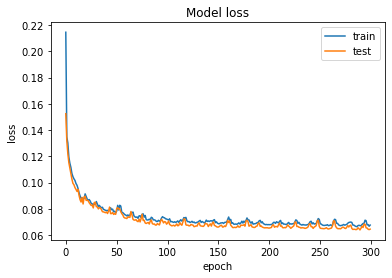

Fold score (MSE):328.38392857142856
Fold score (RMSE):18.121366630898137
Unsupervised Fold #2
X_train =  (1002, 31, 1)
X_test =  (112, 31, 1)
batch_size =  100
Train on 1002 samples, validate on 112 samples
Epoch 1/300
1002/1002 [==============================] - 5s 5ms/step - loss: 0.2123 - val_loss: 0.1471
Epoch 2/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1365 - val_loss: 0.1303
Epoch 3/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1284 - val_loss: 0.1218
Epoch 4/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1162 - val_loss: 0.1148
Epoch 5/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1110 - val_loss: 0.1058
Epoch 6/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1031 - val_loss: 0.1036
Epoch 7/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1058 - val_loss: 0.1014
Epoch 8/300
1002/1002 [==============================] - 1s 1ms/step - l

Epoch 78/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0716 - val_loss: 0.0733
Epoch 79/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0717 - val_loss: 0.0735
Epoch 80/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0717 - val_loss: 0.0726
Epoch 81/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0709 - val_loss: 0.0734
Epoch 82/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0718 - val_loss: 0.0749
Epoch 83/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0736 - val_loss: 0.0749
Epoch 84/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0713 - val_loss: 0.0733
Epoch 85/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0719 - val_loss: 0.0732
Epoch 86/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0729 - val_loss: 0.0764
Epoch 87/300
1002/1002 [==============================] - 1s 1ms

1002/1002 [==============================] - 1s 1ms/step - loss: 0.0695 - val_loss: 0.0702
Epoch 157/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0691 - val_loss: 0.0718
Epoch 158/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0700 - val_loss: 0.0722
Epoch 159/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0707 - val_loss: 0.0708
Epoch 160/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0695 - val_loss: 0.0707
Epoch 161/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0696 - val_loss: 0.0709
Epoch 162/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0698 - val_loss: 0.0708
Epoch 163/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0681 - val_loss: 0.0702
Epoch 164/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0685 - val_loss: 0.0694
Epoch 165/300
1002/1002 [==============================] - 1s 1ms/ste

1002/1002 [==============================] - 1s 1ms/step - loss: 0.0670 - val_loss: 0.0689
Epoch 235/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0671 - val_loss: 0.0676
Epoch 236/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0668 - val_loss: 0.0694
Epoch 237/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0680 - val_loss: 0.0706
Epoch 238/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0686 - val_loss: 0.0692
Epoch 239/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0679 - val_loss: 0.0687
Epoch 240/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0675 - val_loss: 0.0688
Epoch 241/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0673 - val_loss: 0.0687
Epoch 242/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0662 - val_loss: 0.0677
Epoch 243/300
1002/1002 [==============================] - 1s 1ms/ste

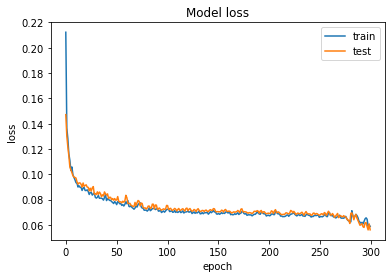

Fold score (MSE):275.0982142857143
Fold score (RMSE):16.58608495955915
Unsupervised Fold #3
X_train =  (1002, 31, 1)
X_test =  (112, 31, 1)
batch_size =  100
Train on 1002 samples, validate on 112 samples
Epoch 1/300
1002/1002 [==============================] - 6s 6ms/step - loss: 0.2114 - val_loss: 0.1366
Epoch 2/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1354 - val_loss: 0.1214
Epoch 3/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1280 - val_loss: 0.1129
Epoch 4/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1154 - val_loss: 0.1059
Epoch 5/300
1002/1002 [==============================] - 2s 2ms/step - loss: 0.1124 - val_loss: 0.1042
Epoch 6/300
1002/1002 [==============================] - 2s 2ms/step - loss: 0.1071 - val_loss: 0.0975
Epoch 7/300
1002/1002 [==============================] - 2s 2ms/step - loss: 0.1031 - val_loss: 0.0990
Epoch 8/300
1002/1002 [==============================] - 2s 2ms/step - los

Epoch 78/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0728 - val_loss: 0.0729
Epoch 79/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0733 - val_loss: 0.0733
Epoch 80/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0737 - val_loss: 0.0737
Epoch 81/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0725 - val_loss: 0.0728
Epoch 82/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0729 - val_loss: 0.0729
Epoch 83/300
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0734 - val_loss: 0.0731
Epoch 84/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0723 - val_loss: 0.0726
Epoch 85/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0728 - val_loss: 0.0731
Epoch 86/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0735 - val_loss: 0.0734
Epoch 87/300
1002/1002 [==============================] - 1s 1ms

1002/1002 [==============================] - 2s 1ms/step - loss: 0.0693 - val_loss: 0.0687
Epoch 157/300
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0685 - val_loss: 0.0688
Epoch 158/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0692 - val_loss: 0.0700
Epoch 159/300
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0698 - val_loss: 0.0695
Epoch 160/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0706 - val_loss: 0.0708
Epoch 161/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0708 - val_loss: 0.0717
Epoch 162/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0707 - val_loss: 0.0692
Epoch 163/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0688 - val_loss: 0.0685
Epoch 164/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0691 - val_loss: 0.0690
Epoch 165/300
1002/1002 [==============================] - 1s 1ms/ste

1002/1002 [==============================] - 1s 1ms/step - loss: 0.0646 - val_loss: 0.0682
Epoch 235/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0696 - val_loss: 0.0669
Epoch 236/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0676 - val_loss: 0.0652
Epoch 237/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0684 - val_loss: 0.0667
Epoch 238/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0656 - val_loss: 0.0646
Epoch 239/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0636 - val_loss: 0.0618
Epoch 240/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0628 - val_loss: 0.0622
Epoch 241/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0617 - val_loss: 0.0668
Epoch 242/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0716 - val_loss: 0.0753
Epoch 243/300
1002/1002 [==============================] - 1s 1ms/ste

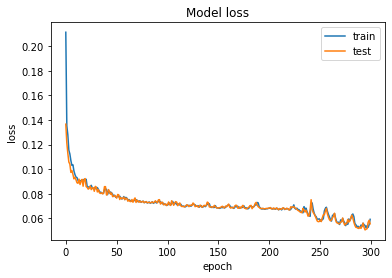

Fold score (MSE):204.95535714285714
Fold score (RMSE):14.316261982195531
Unsupervised Fold #4
X_train =  (1002, 31, 1)
X_test =  (112, 31, 1)
batch_size =  100
Train on 1002 samples, validate on 112 samples
Epoch 1/300
1002/1002 [==============================] - 5s 5ms/step - loss: 0.2045 - val_loss: 0.1371
Epoch 2/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1313 - val_loss: 0.1247
Epoch 3/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1237 - val_loss: 0.1171
Epoch 4/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1142 - val_loss: 0.1110
Epoch 5/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1098 - val_loss: 0.1030
Epoch 6/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.1027 - val_loss: 0.0982
Epoch 7/300
1002/1002 [==============================] - 2s 2ms/step - loss: 0.1035 - val_loss: 0.0975
Epoch 8/300
1002/1002 [==============================] - 2s 2ms/step - l

Epoch 78/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0760 - val_loss: 0.0722
Epoch 79/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0739 - val_loss: 0.0721
Epoch 80/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0758 - val_loss: 0.0746
Epoch 81/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0767 - val_loss: 0.0744
Epoch 82/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0763 - val_loss: 0.0765
Epoch 83/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0764 - val_loss: 0.0698
Epoch 84/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0744 - val_loss: 0.0735
Epoch 85/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0764 - val_loss: 0.0743
Epoch 86/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0756 - val_loss: 0.0705
Epoch 87/300
1002/1002 [==============================] - 1s 1ms

1002/1002 [==============================] - 1s 1ms/step - loss: 0.0698 - val_loss: 0.0672
Epoch 157/300
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0692 - val_loss: 0.0660
Epoch 158/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0688 - val_loss: 0.0664
Epoch 159/300
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0697 - val_loss: 0.0668
Epoch 160/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0694 - val_loss: 0.0661
Epoch 161/300
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0689 - val_loss: 0.0665
Epoch 162/300
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0699 - val_loss: 0.0679
Epoch 163/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0704 - val_loss: 0.0664
Epoch 164/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0688 - val_loss: 0.0663
Epoch 165/300
1002/1002 [==============================] - 1s 1ms/ste

1002/1002 [==============================] - 1s 1ms/step - loss: 0.0648 - val_loss: 0.0628
Epoch 235/300
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0668 - val_loss: 0.0602
Epoch 236/300
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0674 - val_loss: 0.0621
Epoch 237/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0692 - val_loss: 0.0656
Epoch 238/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0687 - val_loss: 0.0626
Epoch 239/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0636 - val_loss: 0.0594
Epoch 240/300
1002/1002 [==============================] - 2s 2ms/step - loss: 0.0615 - val_loss: 0.0589
Epoch 241/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0623 - val_loss: 0.0591
Epoch 242/300
1002/1002 [==============================] - 1s 1ms/step - loss: 0.0626 - val_loss: 0.0591
Epoch 243/300
1002/1002 [==============================] - 1s 1ms/ste

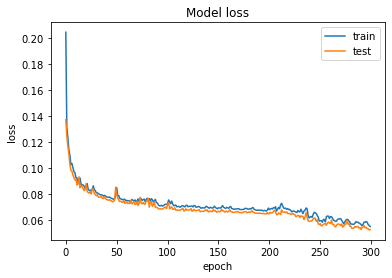

Fold score (MSE):268.20535714285717
Fold score (RMSE):16.376976434704215
Unsupervised Fold #5
X_train =  (1003, 31, 1)
X_test =  (111, 31, 1)
batch_size =  100
Train on 1003 samples, validate on 111 samples
Epoch 1/300
1003/1003 [==============================] - 4s 4ms/step - loss: 0.2142 - val_loss: 0.1472
Epoch 2/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1352 - val_loss: 0.1270
Epoch 3/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1289 - val_loss: 0.1187
Epoch 4/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1171 - val_loss: 0.1134
Epoch 5/300
1003/1003 [==============================] - 2s 2ms/step - loss: 0.1137 - val_loss: 0.1056
Epoch 6/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1079 - val_loss: 0.1026
Epoch 7/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1059 - val_loss: 0.0989
Epoch 8/300
1003/1003 [==============================] - 1s 1ms/step - l

Epoch 78/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0744 - val_loss: 0.0717
Epoch 79/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0749 - val_loss: 0.0733
Epoch 80/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0743 - val_loss: 0.0724
Epoch 81/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0752 - val_loss: 0.0721
Epoch 82/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0754 - val_loss: 0.0739
Epoch 83/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0746 - val_loss: 0.0728
Epoch 84/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0754 - val_loss: 0.0714
Epoch 85/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0746 - val_loss: 0.0728
Epoch 86/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0739 - val_loss: 0.0720
Epoch 87/300
1003/1003 [==============================] - 1s 1ms

1003/1003 [==============================] - 2s 2ms/step - loss: 0.0699 - val_loss: 0.0684
Epoch 157/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0710 - val_loss: 0.0710
Epoch 158/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0725 - val_loss: 0.0716
Epoch 159/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0735 - val_loss: 0.0692
Epoch 160/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0701 - val_loss: 0.0681
Epoch 161/300
1003/1003 [==============================] - 2s 2ms/step - loss: 0.0703 - val_loss: 0.0673
Epoch 162/300
1003/1003 [==============================] - 2s 2ms/step - loss: 0.0694 - val_loss: 0.0676
Epoch 163/300
1003/1003 [==============================] - 2s 2ms/step - loss: 0.0693 - val_loss: 0.0677
Epoch 164/300
1003/1003 [==============================] - 2s 2ms/step - loss: 0.0697 - val_loss: 0.0671
Epoch 165/300
1003/1003 [==============================] - 2s 2ms/ste

1003/1003 [==============================] - 1s 1ms/step - loss: 0.0678 - val_loss: 0.0662
Epoch 235/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0679 - val_loss: 0.0660
Epoch 236/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0674 - val_loss: 0.0660
Epoch 237/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0676 - val_loss: 0.0658
Epoch 238/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0678 - val_loss: 0.0663
Epoch 239/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0680 - val_loss: 0.0666
Epoch 240/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0684 - val_loss: 0.0664
Epoch 241/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0677 - val_loss: 0.0660
Epoch 242/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0675 - val_loss: 0.0656
Epoch 243/300
1003/1003 [==============================] - 1s 1ms/ste

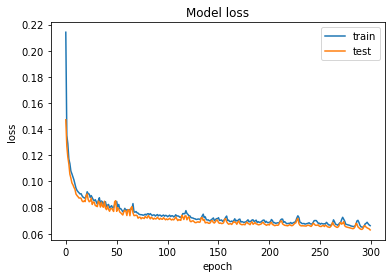

Fold score (MSE):307.9009009009009
Fold score (RMSE):17.54710520002946
Unsupervised Fold #6
X_train =  (1003, 31, 1)
X_test =  (111, 31, 1)
batch_size =  100
Train on 1003 samples, validate on 111 samples
Epoch 1/300
1003/1003 [==============================] - 5s 5ms/step - loss: 0.2102 - val_loss: 0.1453
Epoch 2/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1377 - val_loss: 0.1297
Epoch 3/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1277 - val_loss: 0.1204
Epoch 4/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1165 - val_loss: 0.1148
Epoch 5/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1126 - val_loss: 0.1071
Epoch 6/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1038 - val_loss: 0.1037
Epoch 7/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1010 - val_loss: 0.0983
Epoch 8/300
1003/1003 [==============================] - 2s 2ms/step - los

Epoch 78/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0741 - val_loss: 0.0760
Epoch 79/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0747 - val_loss: 0.0762
Epoch 80/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0735 - val_loss: 0.0756
Epoch 81/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0731 - val_loss: 0.0757
Epoch 82/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0735 - val_loss: 0.0764
Epoch 83/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0734 - val_loss: 0.0753
Epoch 84/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0735 - val_loss: 0.0772
Epoch 85/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0742 - val_loss: 0.0780
Epoch 86/300
1003/1003 [==============================] - 2s 2ms/step - loss: 0.0743 - val_loss: 0.0754
Epoch 87/300
1003/1003 [==============================] - 1s 1ms

1003/1003 [==============================] - 1s 1ms/step - loss: 0.0692 - val_loss: 0.0713
Epoch 157/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0695 - val_loss: 0.0716
Epoch 158/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0702 - val_loss: 0.0729
Epoch 159/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0705 - val_loss: 0.0732
Epoch 160/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0709 - val_loss: 0.0714
Epoch 161/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0700 - val_loss: 0.0722
Epoch 162/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0700 - val_loss: 0.0728
Epoch 163/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0707 - val_loss: 0.0713
Epoch 164/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0691 - val_loss: 0.0715
Epoch 165/300
1003/1003 [==============================] - 1s 1ms/ste

1003/1003 [==============================] - 1s 1ms/step - loss: 0.0675 - val_loss: 0.0690
Epoch 235/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0683 - val_loss: 0.0702
Epoch 236/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0682 - val_loss: 0.0714
Epoch 237/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0695 - val_loss: 0.0700
Epoch 238/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0679 - val_loss: 0.0699
Epoch 239/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0683 - val_loss: 0.0687
Epoch 240/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0677 - val_loss: 0.0684
Epoch 241/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0667 - val_loss: 0.0682
Epoch 242/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0667 - val_loss: 0.0680
Epoch 243/300
1003/1003 [==============================] - 1s 1ms/ste

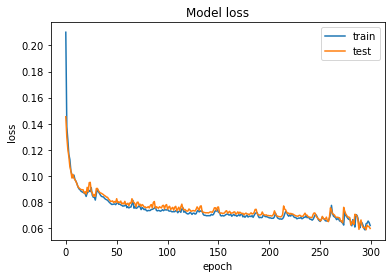

Fold score (MSE):282.5405405405405
Fold score (RMSE):16.808942279053152
Unsupervised Fold #7
X_train =  (1003, 31, 1)
X_test =  (111, 31, 1)
batch_size =  100
Train on 1003 samples, validate on 111 samples
Epoch 1/300
1003/1003 [==============================] - 5s 5ms/step - loss: 0.2024 - val_loss: 0.1343
Epoch 2/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1299 - val_loss: 0.1168
Epoch 3/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1201 - val_loss: 0.1084
Epoch 4/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1095 - val_loss: 0.1016
Epoch 5/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1078 - val_loss: 0.1020
Epoch 6/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1048 - val_loss: 0.0968
Epoch 7/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0998 - val_loss: 0.0936
Epoch 8/300
1003/1003 [==============================] - 1s 1ms/step - lo

Epoch 78/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0736 - val_loss: 0.0728
Epoch 79/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0744 - val_loss: 0.0735
Epoch 80/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0731 - val_loss: 0.0731
Epoch 81/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0740 - val_loss: 0.0724
Epoch 82/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0739 - val_loss: 0.0729
Epoch 83/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0727 - val_loss: 0.0724
Epoch 84/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0734 - val_loss: 0.0726
Epoch 85/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0740 - val_loss: 0.0728
Epoch 86/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0726 - val_loss: 0.0720
Epoch 87/300
1003/1003 [==============================] - 1s 1ms

1003/1003 [==============================] - 1s 1ms/step - loss: 0.0713 - val_loss: 0.0692
Epoch 157/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0694 - val_loss: 0.0691
Epoch 158/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0700 - val_loss: 0.0677
Epoch 159/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0689 - val_loss: 0.0680
Epoch 160/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0691 - val_loss: 0.0691
Epoch 161/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0699 - val_loss: 0.0684
Epoch 162/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0698 - val_loss: 0.0695
Epoch 163/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0707 - val_loss: 0.0706
Epoch 164/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0712 - val_loss: 0.0687
Epoch 165/300
1003/1003 [==============================] - 1s 1ms/ste

1003/1003 [==============================] - 1s 1ms/step - loss: 0.0680 - val_loss: 0.0660
Epoch 235/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0676 - val_loss: 0.0669
Epoch 236/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0683 - val_loss: 0.0685
Epoch 237/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0686 - val_loss: 0.0664
Epoch 238/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0687 - val_loss: 0.0674
Epoch 239/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0689 - val_loss: 0.0680
Epoch 240/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0675 - val_loss: 0.0656
Epoch 241/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0663 - val_loss: 0.0654
Epoch 242/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0673 - val_loss: 0.0660
Epoch 243/300
1003/1003 [==============================] - 2s 2ms/ste

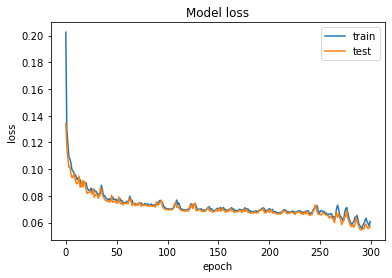

Fold score (MSE):171.72972972972974
Fold score (RMSE):13.10456904021379
Unsupervised Fold #8
X_train =  (1003, 31, 1)
X_test =  (111, 31, 1)
batch_size =  100
Train on 1003 samples, validate on 111 samples
Epoch 1/300
1003/1003 [==============================] - 5s 5ms/step - loss: 0.2010 - val_loss: 0.1566
Epoch 2/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1439 - val_loss: 0.1341
Epoch 3/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1282 - val_loss: 0.1243
Epoch 4/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1192 - val_loss: 0.1146
Epoch 5/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1111 - val_loss: 0.1059
Epoch 6/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1073 - val_loss: 0.1043
Epoch 7/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1052 - val_loss: 0.0980
Epoch 8/300
1003/1003 [==============================] - 1s 1ms/step - lo

Epoch 78/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0740 - val_loss: 0.0738
Epoch 79/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0729 - val_loss: 0.0728
Epoch 80/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0739 - val_loss: 0.0750
Epoch 81/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0748 - val_loss: 0.0742
Epoch 82/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0733 - val_loss: 0.0729
Epoch 83/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0749 - val_loss: 0.0747
Epoch 84/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0739 - val_loss: 0.0727
Epoch 85/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0730 - val_loss: 0.0729
Epoch 86/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0736 - val_loss: 0.0747
Epoch 87/300
1003/1003 [==============================] - 1s 1ms

1003/1003 [==============================] - 1s 1ms/step - loss: 0.0682 - val_loss: 0.0678
Epoch 157/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0680 - val_loss: 0.0676
Epoch 158/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0681 - val_loss: 0.0678
Epoch 159/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0685 - val_loss: 0.0681
Epoch 160/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0687 - val_loss: 0.0683
Epoch 161/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0689 - val_loss: 0.0699
Epoch 162/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0702 - val_loss: 0.0704
Epoch 163/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0702 - val_loss: 0.0695
Epoch 164/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0704 - val_loss: 0.0695
Epoch 165/300
1003/1003 [==============================] - 1s 1ms/ste

1003/1003 [==============================] - 1s 1ms/step - loss: 0.0654 - val_loss: 0.0680
Epoch 235/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0696 - val_loss: 0.0665
Epoch 236/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0658 - val_loss: 0.0653
Epoch 237/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0649 - val_loss: 0.0644
Epoch 238/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0640 - val_loss: 0.0650
Epoch 239/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0660 - val_loss: 0.0725
Epoch 240/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0719 - val_loss: 0.0677
Epoch 241/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0685 - val_loss: 0.0659
Epoch 242/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0651 - val_loss: 0.0622
Epoch 243/300
1003/1003 [==============================] - 1s 1ms/ste

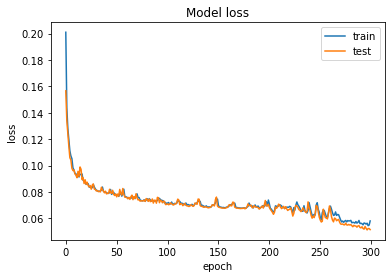

Fold score (MSE):175.33333333333334
Fold score (RMSE):13.241349377360804
Unsupervised Fold #9
X_train =  (1003, 31, 1)
X_test =  (111, 31, 1)
batch_size =  100
Train on 1003 samples, validate on 111 samples
Epoch 1/300
1003/1003 [==============================] - 4s 4ms/step - loss: 0.2116 - val_loss: 0.1513
Epoch 2/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1353 - val_loss: 0.1312
Epoch 3/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1266 - val_loss: 0.1212
Epoch 4/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1138 - val_loss: 0.1085
Epoch 5/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1117 - val_loss: 0.1078
Epoch 6/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1082 - val_loss: 0.1037
Epoch 7/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1024 - val_loss: 0.0999
Epoch 8/300
1003/1003 [==============================] - 1s 1ms/step - l

Epoch 78/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0735 - val_loss: 0.0729
Epoch 79/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0730 - val_loss: 0.0729
Epoch 80/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0728 - val_loss: 0.0728
Epoch 81/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0727 - val_loss: 0.0728
Epoch 82/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0727 - val_loss: 0.0726
Epoch 83/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0726 - val_loss: 0.0726
Epoch 84/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0726 - val_loss: 0.0726
Epoch 85/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0728 - val_loss: 0.0725
Epoch 86/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0726 - val_loss: 0.0725
Epoch 87/300
1003/1003 [==============================] - 1s 1ms

1003/1003 [==============================] - 1s 1ms/step - loss: 0.0715 - val_loss: 0.0716
Epoch 157/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0714 - val_loss: 0.0695
Epoch 158/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0702 - val_loss: 0.0700
Epoch 159/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0705 - val_loss: 0.0702
Epoch 160/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0710 - val_loss: 0.0693
Epoch 161/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0705 - val_loss: 0.0705
Epoch 162/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0706 - val_loss: 0.0706
Epoch 163/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0710 - val_loss: 0.0689
Epoch 164/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0700 - val_loss: 0.0702
Epoch 165/300
1003/1003 [==============================] - 1s 1ms/ste

1003/1003 [==============================] - 1s 1ms/step - loss: 0.0679 - val_loss: 0.0669
Epoch 235/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0681 - val_loss: 0.0672
Epoch 236/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0677 - val_loss: 0.0665
Epoch 237/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0677 - val_loss: 0.0672
Epoch 238/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0677 - val_loss: 0.0672
Epoch 239/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0678 - val_loss: 0.0669
Epoch 240/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0671 - val_loss: 0.0667
Epoch 241/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0677 - val_loss: 0.0673
Epoch 242/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0678 - val_loss: 0.0668
Epoch 243/300
1003/1003 [==============================] - 1s 1ms/ste

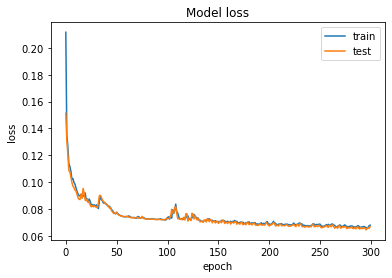

Fold score (MSE):287.5405405405405
Fold score (RMSE):16.95702039099265
Unsupervised Fold #10
X_train =  (1003, 31, 1)
X_test =  (111, 31, 1)
batch_size =  100
Train on 1003 samples, validate on 111 samples
Epoch 1/300
1003/1003 [==============================] - 5s 5ms/step - loss: 0.2009 - val_loss: 0.1384
Epoch 2/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1351 - val_loss: 0.1251
Epoch 3/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1255 - val_loss: 0.1163
Epoch 4/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1146 - val_loss: 0.1079
Epoch 5/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1097 - val_loss: 0.1003
Epoch 6/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1043 - val_loss: 0.0985
Epoch 7/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.1024 - val_loss: 0.0962
Epoch 8/300
1003/1003 [==============================] - 1s 1ms/step - lo

Epoch 78/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0755 - val_loss: 0.0756
Epoch 79/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0762 - val_loss: 0.0727
Epoch 80/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0748 - val_loss: 0.0717
Epoch 81/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0731 - val_loss: 0.0697
Epoch 82/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0715 - val_loss: 0.0687
Epoch 83/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0714 - val_loss: 0.0696
Epoch 84/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0729 - val_loss: 0.0691
Epoch 85/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0708 - val_loss: 0.0687
Epoch 86/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0720 - val_loss: 0.0716
Epoch 87/300
1003/1003 [==============================] - 1s 1ms

1003/1003 [==============================] - 1s 1ms/step - loss: 0.0690 - val_loss: 0.0659
Epoch 157/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0683 - val_loss: 0.0659
Epoch 158/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0689 - val_loss: 0.0668
Epoch 159/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0693 - val_loss: 0.0657
Epoch 160/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0683 - val_loss: 0.0659
Epoch 161/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0689 - val_loss: 0.0670
Epoch 162/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0691 - val_loss: 0.0655
Epoch 163/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0682 - val_loss: 0.0658
Epoch 164/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0685 - val_loss: 0.0667
Epoch 165/300
1003/1003 [==============================] - 1s 1ms/ste

1003/1003 [==============================] - 1s 1ms/step - loss: 0.0539 - val_loss: 0.0472
Epoch 235/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0523 - val_loss: 0.0472
Epoch 236/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0524 - val_loss: 0.0481
Epoch 237/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0544 - val_loss: 0.0478
Epoch 238/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0518 - val_loss: 0.0458
Epoch 239/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0511 - val_loss: 0.0457
Epoch 240/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0516 - val_loss: 0.0475
Epoch 241/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0529 - val_loss: 0.0462
Epoch 242/300
1003/1003 [==============================] - 1s 1ms/step - loss: 0.0512 - val_loss: 0.0469
Epoch 243/300
1003/1003 [==============================] - 1s 1ms/ste

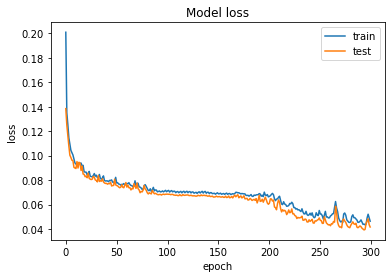

Fold score (MSE):89.2072072072072
Fold score (RMSE):9.444956707534832


In [23]:
kf = KFold(10, shuffle = True, random_state = 42)
oos_x = []
oos_pred_x = []
fold = 0

for train, test in kf.split(X):
    fold+=1
    print(f"Unsupervised Fold #{fold}")
    
    X_train = X[train]
    X_test = X[test]
    Y_train = Y[train]
    Y_test = Y[test]
    
    # expand dimensions
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    print('X_train = ',X_train.shape) 
    print('X_test = ',X_test.shape)
    
    batch_size = round ((1/10)*1002)   #140860
    print('batch_size = ', batch_size)
    
    #proposed architecture of LSTM model
    # define model
    encoder_decoder = Sequential()
    encoder_decoder.add(LSTM(31, activation='elu', input_shape = X_train[1].shape, \
                         return_sequences=True)) #try units = 50
    encoder_decoder.add(Dropout(0.3)) 
    encoder_decoder.add(LSTM(20, activation='elu', return_sequences=True))
    encoder_decoder.add(Dropout(0.3)) 

    encoder_decoder.add(LSTM(10, activation='elu', return_sequences=False, name="bottleneck"))
    encoder_decoder.add(RepeatVector(31))
    encoder_decoder.add(LSTM(10, activation='elu', return_sequences=True))

    encoder_decoder.add(Dropout(0.3))
    encoder_decoder.add(LSTM(20, activation='elu', return_sequences=True))
    encoder_decoder.add(Dropout(0.3)) 
    encoder_decoder.add(LSTM(31, activation='elu', return_sequences=True))
    encoder_decoder.add(TimeDistributed(Dense(1)))
    #encoder_decoder.compile(loss='mean_squared_error', optimizer='adam')
    encoder_decoder.compile(loss='mse', optimizer='adam')
   
    history = encoder_decoder.fit(X_train, X_train, epochs = 300, batch_size = batch_size, \
                                shuffle = False, validation_data=[X_test, X_test])
    rpt_vector_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[2].output)
    time_dist_layer = Model(inputs=encoder_decoder.inputs, outputs=encoder_decoder.layers[5].output)
    encoder = Model(inputs=encoder_decoder.inputs,\
                    outputs=encoder_decoder.get_layer('bottleneck').output)
    
    model_name = get_model_name(fold)
    encoder_decoder.save('D:/data/k_fold_unsupervised/mendaly_data/'+model_name,'h5')
    
    encoder_model_name = get_encoder_model_name(fold)
    encoder.save('D:/data/k_fold_unsupervised/mendaly_data/'+encoder_model_name,'h5')
    
    plt.plot(history.history['loss'], label = 'loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    pred = encoder_decoder.predict(X_test)
    oos_x.append(X_test)
    #print(oos_x)
    compare_X_test = np.argmax(X_test, axis = 1)
    pred = np.argmax(pred, axis = 1)
    oos_pred_x.append(pred)
    #print(oos_pred_x)
    
    MSE_score = mean_squared_error(pred, compare_X_test)
    print(f"Fold score (MSE):{MSE_score}")
    RMSE_score = np.sqrt(mean_squared_error(pred, compare_X_test))
    print(f"Fold score (RMSE):{RMSE_score}")
    

In [24]:
#build the prediction list and calculate error
oos_x = np.concatenate(oos_x)
oos_pred_x = np.concatenate(oos_pred_x)
oos_x_compare = np.argmax(oos_x, axis=1) #for accuracy calculation
score = np.sqrt(mean_squared_error(oos_pred_x, oos_x_compare))
print(f"Final score (RMSE):{score}")

Final score (RMSE):15.466010685855903


In [25]:
#https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/